# CHIPS-CVN Explain Notebook

In [1]:
# Import all the required modules and call the gpu_setup utility
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import chipscvn.utils as utils
import chipscvn.config as config
utils.gpu_setup()  # Setup the GPU's

/mnt/storage/jtingey/chips-cvn/env/miniconda/envs/chips-cvn/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Welcome to JupyROOT 6.18/04
---  4 Physical GPUs, 4 Logical GPUs ---


In [2]:
# Load the trained models from the configuration and run the evaluator
conf = config.get("config/tsne.yml")
evaluator = utils.get_evaluator(conf)
evaluator.run()

--- Running Evaluation ---

--- running inference...

--- parsing outputs...

--- calculating weights...

Total-> Nuel: 7499, Numu: 7487, Cosmic: 1014

Weights-> Nuel:0.0105, Numu:0.4554, Cosmic:1193.9819

--- calculating cuts...

Cat 0-> Total 3946, Survived: 0.927521540800811

Cat 1-> Total 3900, Survived: 0.8935897435897436

Cat 2-> Total 7140, Survived: 0.4519607843137255

Cat 3-> Total 1014, Survived: 0.0009861932938856016

--- Done (took 52.39164423942566 seconds) ---



2020-03-17 14:30:57.742073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-03-17 14:30:58.048576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


In [21]:
from sklearn.preprocessing import StandardScaler

N = 1000
data = []
for i in range(10):
    data.append(evaluator.events[evaluator.events.true_category == i][:N])
data = pd.concat(data)
data = data[['true_category', 'true_cat_combined', 'true_cosmic', 'cosmic_dense', 'beam_dense']]
data = data.sample(frac=1).reset_index(drop=True)

# Get the dense outputs
cosmic_dense = np.stack(data['cosmic_dense'])
beam_dense = np.stack(data['beam_dense'])

# Standardize the dense layer outputs by removing the mean and scaling to unit variance
scaler = StandardScaler()
cosmic_dense_scaled = scaler.fit_transform(cosmic_dense)
beam_dense_scaled = scaler.fit_transform(beam_dense)

In [22]:
cosmic_pca = PCA(n_components=3)
cosmic_pca_result = cosmic_pca.fit_transform(cosmic_dense_scaled)
cosmic_pca_df = pd.DataFrame(cosmic_pca_result)
data['cosmic-pca-0'] = cosmic_pca_df[0]
data['cosmic-pca-1'] = cosmic_pca_df[1]
data['cosmic-pca-2'] = cosmic_pca_df[2]
print('Explained variation per principal component: {}'.format(cosmic_pca.explained_variance_ratio_))

beam_pca = PCA(n_components=3)
beam_pca_result = beam_pca.fit_transform(beam_dense_scaled)
beam_pca_df = pd.DataFrame(beam_pca_result)
data['beam-pca-0'] = beam_pca_df[0]
data['beam-pca-1'] = beam_pca_df[1]
data['beam-pca-2'] = beam_pca_df[2]
print('Explained variation per principal component: {}'.format(beam_pca.explained_variance_ratio_))

Explained variation per principal component: [0.5678033  0.2284657  0.05239307]
Explained variation per principal component: [0.25927222 0.16487445 0.13642536]


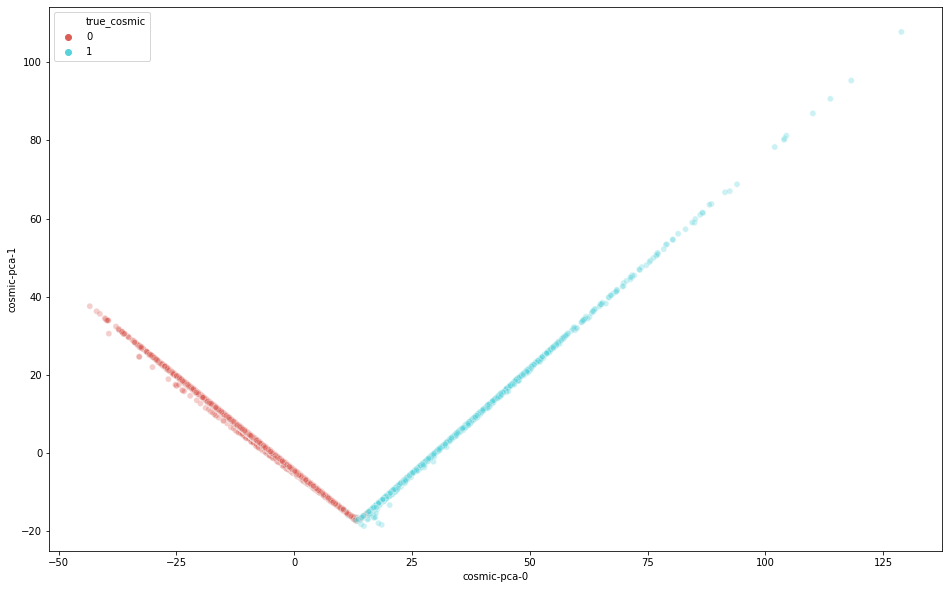

In [23]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="cosmic-pca-0", y="cosmic-pca-1",
    hue="true_cosmic",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)
plt.show()

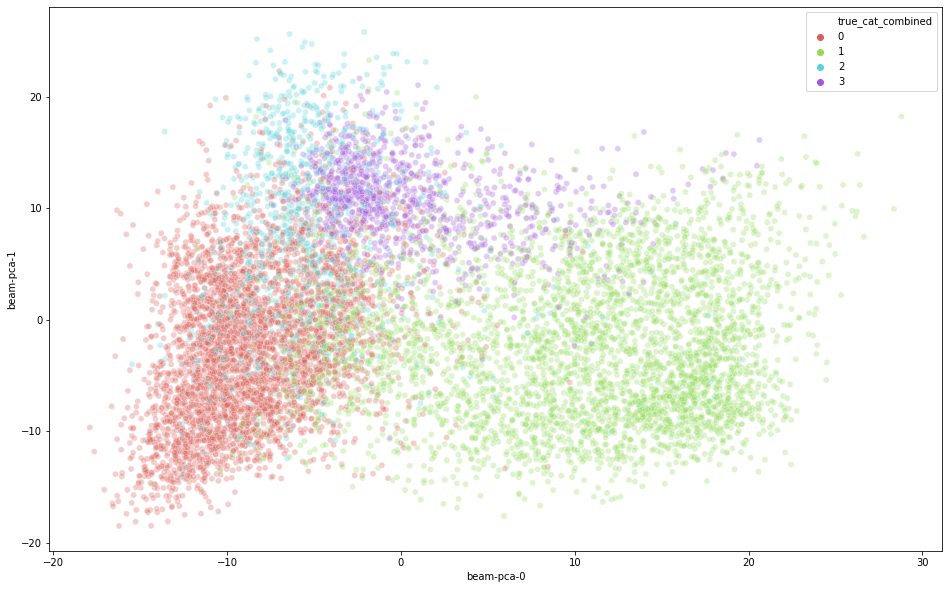

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="beam-pca-0", y="beam-pca-1",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=data,
    legend="full",
    alpha=0.3
)
plt.show()

In [28]:
cosmic_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
cosmic_tsne_results = cosmic_tsne.fit_transform(cosmic_dense_scaled)
cosmic_tsne_df = pd.DataFrame(cosmic_tsne_results)
data['cosmic-tsne-0'] = cosmic_tsne_df[0]
data['cosmic-tsne-1'] = cosmic_tsne_df[1]

beam_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
beam_tsne_results = beam_tsne.fit_transform(beam_dense_scaled)
beam_tsne_df = pd.DataFrame(beam_tsne_results)
data['beam-tsne-0'] = beam_tsne_df[0]
data['beam-tsne-1'] = beam_tsne_df[1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9771 samples in 1.083s...
[t-SNE] Computed neighbors for 9771 samples in 123.850s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9771
[t-SNE] Computed conditional probabilities for sample 2000 / 9771
[t-SNE] Computed conditional probabilities for sample 3000 / 9771
[t-SNE] Computed conditional probabilities for sample 4000 / 9771
[t-SNE] Computed conditional probabilities for sample 5000 / 9771
[t-SNE] Computed conditional probabilities for sample 6000 / 9771
[t-SNE] Computed conditional probabilities for sample 7000 / 9771
[t-SNE] Computed conditional probabilities for sample 8000 / 9771
[t-SNE] Computed conditional probabilities for sample 9000 / 9771
[t-SNE] Computed conditional probabilities for sample 9771 / 9771
[t-SNE] Mean sigma: 0.856057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.387360
[t-SNE] KL divergence after 300 iterations: 2.342914
[t-SNE] Computing 121 nearest neighb

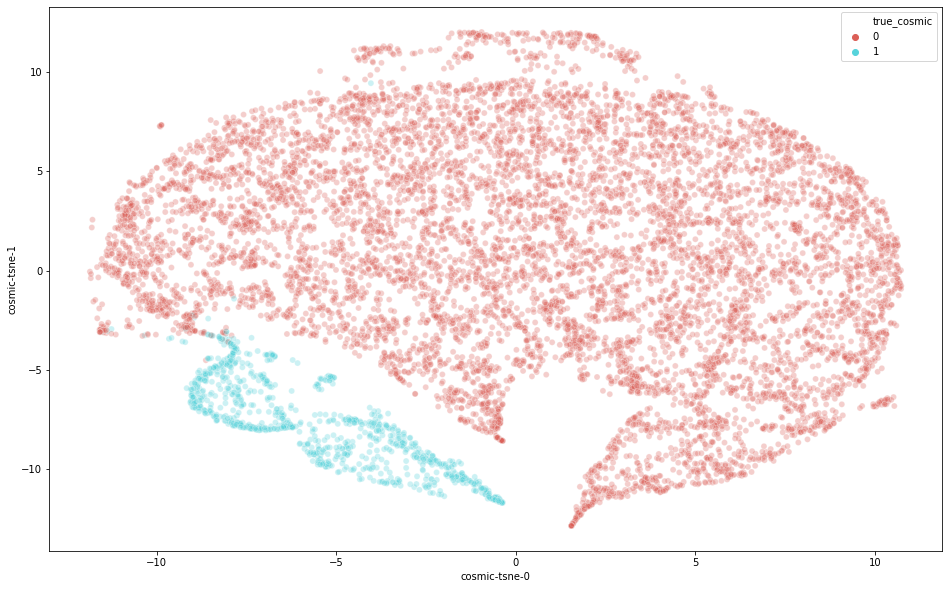

In [29]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="cosmic-tsne-0", y="cosmic-tsne-1",
    hue="true_cosmic",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)

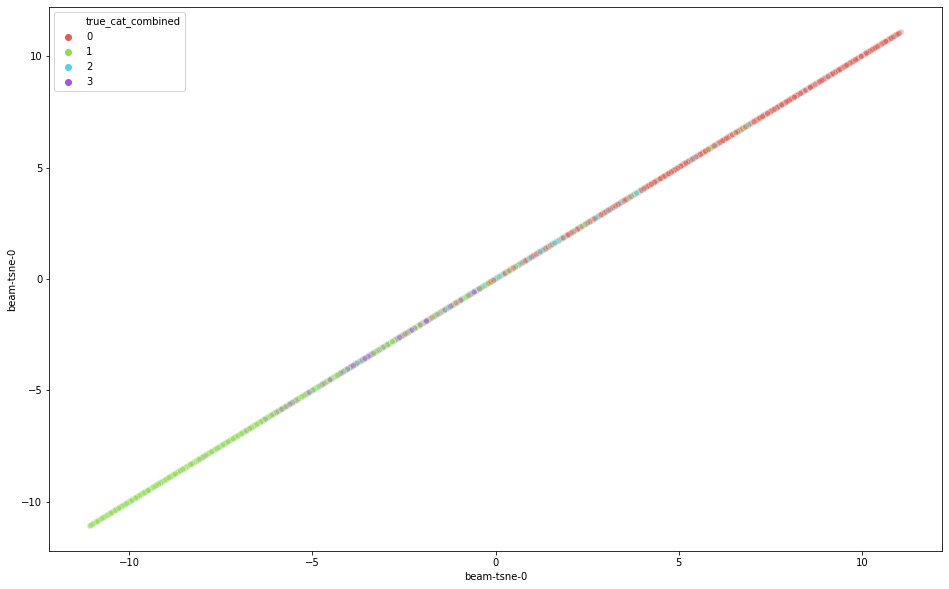

In [30]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="beam-tsne-0", y="beam-tsne-0",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=data,
    legend="full",
    alpha=0.3
)